<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [15]:
# Importing Training Set
dataset_train = pd.read_csv('GOOG.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

            Date         Open         High          Low        Close  \
0     2004-08-19    49.813286    51.835709    47.800831    49.982655   
1     2004-08-20    50.316402    54.336334    50.062355    53.952770   
2     2004-08-23    55.168217    56.528118    54.321388    54.495735   
3     2004-08-24    55.412300    55.591629    51.591621    52.239193   
4     2004-08-25    52.284027    53.798351    51.746044    52.802086   
...          ...          ...          ...          ...          ...   
4001  2020-07-13  1550.000000  1577.131958  1505.243042  1511.339966   
4002  2020-07-14  1490.310059  1522.949951  1483.500000  1520.579956   
4003  2020-07-15  1523.130005  1535.329956  1498.000000  1513.640015   
4004  2020-07-16  1500.000000  1518.689941  1486.310059  1518.000000   
4005  2020-07-17  1521.619995  1523.439941  1498.420044  1515.550049   

        Adj Close    Volume  
0       49.982655  44871300  
1       53.952770  22942800  
2       54.495735  18342800  
3       52.2391

<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [4]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (4006, 5).


array([[  49.813286,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.27195197],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [6]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3857, 90, 4).
y_train shape == (3857, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [7]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [8]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [10]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=1, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

12/13 [==========================>...] - ETA: 0s - loss: 0.0488
Epoch 1: val_loss improved from inf to 0.40790, saving model to weights.h5
13/13 [==============================] - 1s 99ms/step - loss: 0.0486 - val_loss: 0.4079 - lr: 0.0100
CPU times: total: 1.44 s
Wall time: 1.4 s


<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [22]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())
print(datelist_future_)

[datetime.date(2020, 7, 17), datetime.date(2020, 7, 18), datetime.date(2020, 7, 19), datetime.date(2020, 7, 20), datetime.date(2020, 7, 21), datetime.date(2020, 7, 22), datetime.date(2020, 7, 23), datetime.date(2020, 7, 24), datetime.date(2020, 7, 25), datetime.date(2020, 7, 26), datetime.date(2020, 7, 27), datetime.date(2020, 7, 28), datetime.date(2020, 7, 29), datetime.date(2020, 7, 30), datetime.date(2020, 7, 31), datetime.date(2020, 8, 1), datetime.date(2020, 8, 2), datetime.date(2020, 8, 3), datetime.date(2020, 8, 4), datetime.date(2020, 8, 5), datetime.date(2020, 8, 6), datetime.date(2020, 8, 7), datetime.date(2020, 8, 8), datetime.date(2020, 8, 9), datetime.date(2020, 8, 10), datetime.date(2020, 8, 11), datetime.date(2020, 8, 12), datetime.date(2020, 8, 13), datetime.date(2020, 8, 14), datetime.date(2020, 8, 15), datetime.date(2020, 8, 16), datetime.date(2020, 8, 17), datetime.date(2020, 8, 18), datetime.date(2020, 8, 19), datetime.date(2020, 8, 20), datetime.date(2020, 8, 21), 

<h3>Step #5. Make predictions for future dates</h3>

In [12]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

118/118 [==============================] - 1s 10ms/step


In [13]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2005-08-01,180.835709
2005-08-02,181.392258
2005-08-03,181.923904


<h3>Step #6. Visualize the Predictions</h3>

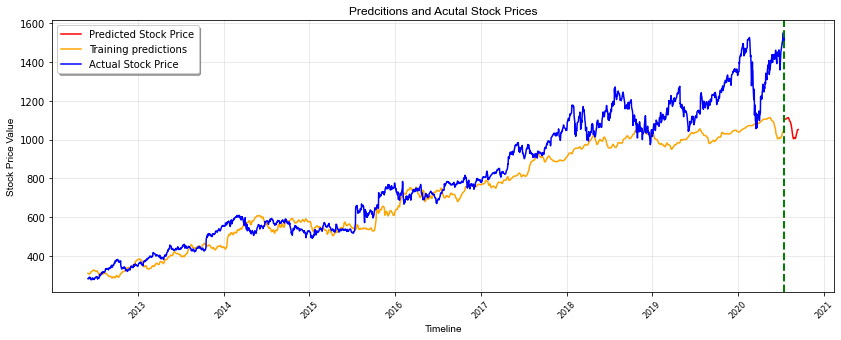

In [17]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [16]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)